In [3]:
# Import Python Libraries used in this notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from datetime import datetime, timedelta

# Turn off Warnings
warnings.filterwarnings("ignore")

# Load Data and perform some pre-processing

In [4]:
# Load Dataset
home_df = pd.read_csv('HomeC.csv')

# Drop last row which has bad data
home_df = home_df[:len(home_df)-1]

# Rename column to make it easier to work with
home_df.rename(columns={'Solar [kW]': 'Solar', }, inplace=True)

# Create a DateTime column from the current Unix time column
home_df['Datetime'] = pd.to_datetime(home_df['time'], unit='s', errors='coerce') - timedelta(hours=5)
home_df['Datetime'] = pd.date_range(start=home_df['Datetime'].min(), periods=len(home_df), freq='min')

# Backfill cloudCover data that is incorrectly filled with 'cloudCover'
home_df['cloudCover'].replace(['cloudCover'], method='bfill', inplace=True) 
home_df['cloudCover'] = home_df['cloudCover'].astype('float') 
home_df.head()

,time,use [kW],gen [kW],House overall [kW],Dishwasher [kW],Furnace 1 [kW],Furnace 2 [kW],Home office [kW],Fridge [kW],Wine cellar [kW],...,summary,apparentTemperature,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability,Datetime
0,1451624400,0.932833,0.003483,0.932833,0.000033,0.020700,0.061917,0.442633,0.124150,0.006983,...,Clear,29.26,1016.91,9.18,0.75,282.0,0.0,24.4,0.0,2016-01-01 00:00:00
1,1451624401,0.934333,0.003467,0.934333,0.000000,0.020717,0.063817,0.444067,0.124000,0.006983,...,Clear,29.26,1016.91,9.18,0.75,282.0,0.0,24.4,0.0,2016-01-01 00:01:00
2,1451624402,0.931817,0.003467,0.931817,0.000017,0.020700,0.062317,0.446067,0.123533,0.006983,...,Clear,29.26,1016.91,9.18,0.75,282.0,0.0,24.4,0.0,2016-01-01 00:02:00
3,1451624403,1.022050,0.003483,1.022050,0.000017,0.106900,0.068517,0.446583,0.123133,0.006983,...,Clear,29.26,1016.91,9.18,0.75,282.0,0.0,24.4,0.0,2016-01-01 00:03:00
4,1451624404,1.139400,0.003467,1.139400,0.000133,0.236933,0.063983,0.446533,0.122850,0.006850,...,Clear,29.26,1016.91,9.18,0.75,282.0,0.0,24.4,0.0,2016-01-01 00:04:00


# Explore data related to Solar [kW] generation.

The dataset contains data on total energy usage in a smart home across appliances and rooms.  It also contains information on Solar energy generation (Solar [kW]), and weather information.  We want to explore what factors contribute to Solar energy generation in order to build a model that can be used by a consumer to inform what expected solar output will be in the future.  This can help a homeowner manage their power consumption.


In [5]:
# Select key columns relevant to Solar data exploration (i.e. we don't need home energy usage data for this exploration)
solar_df = home_df[['time', 'Solar', 'temperature', 'icon', 'humidity', 'visibility', 'summary', 'apparentTemperature', 
                   'pressure', 'windSpeed', 'cloudCover', 'windBearing', 'precipIntensity', 'dewPoint', 'precipProbability']]

# Output Solar Dataframe
solar_df.head()


,time,Solar,temperature,icon,humidity,visibility,summary,apparentTemperature,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability
0,1451624400,0.003483,36.14,clear-night,0.62,10.0,Clear,29.26,1016.91,9.18,0.75,282.0,0.0,24.4,0.0
1,1451624401,0.003467,36.14,clear-night,0.62,10.0,Clear,29.26,1016.91,9.18,0.75,282.0,0.0,24.4,0.0
2,1451624402,0.003467,36.14,clear-night,0.62,10.0,Clear,29.26,1016.91,9.18,0.75,282.0,0.0,24.4,0.0
3,1451624403,0.003483,36.14,clear-night,0.62,10.0,Clear,29.26,1016.91,9.18,0.75,282.0,0.0,24.4,0.0
4,1451624404,0.003467,36.14,clear-night,0.62,10.0,Clear,29.26,1016.91,9.18,0.75,282.0,0.0,24.4,0.0


array([<Axes: xlabel='time'>, <Axes: xlabel='time'>,
       <Axes: xlabel='time'>, <Axes: xlabel='time'>,
       <Axes: xlabel='time'>, <Axes: xlabel='time'>,
       <Axes: xlabel='time'>, <Axes: xlabel='time'>,
       <Axes: xlabel='time'>, <Axes: xlabel='time'>,
       <Axes: xlabel='time'>, <Axes: xlabel='time'>], dtype=object)

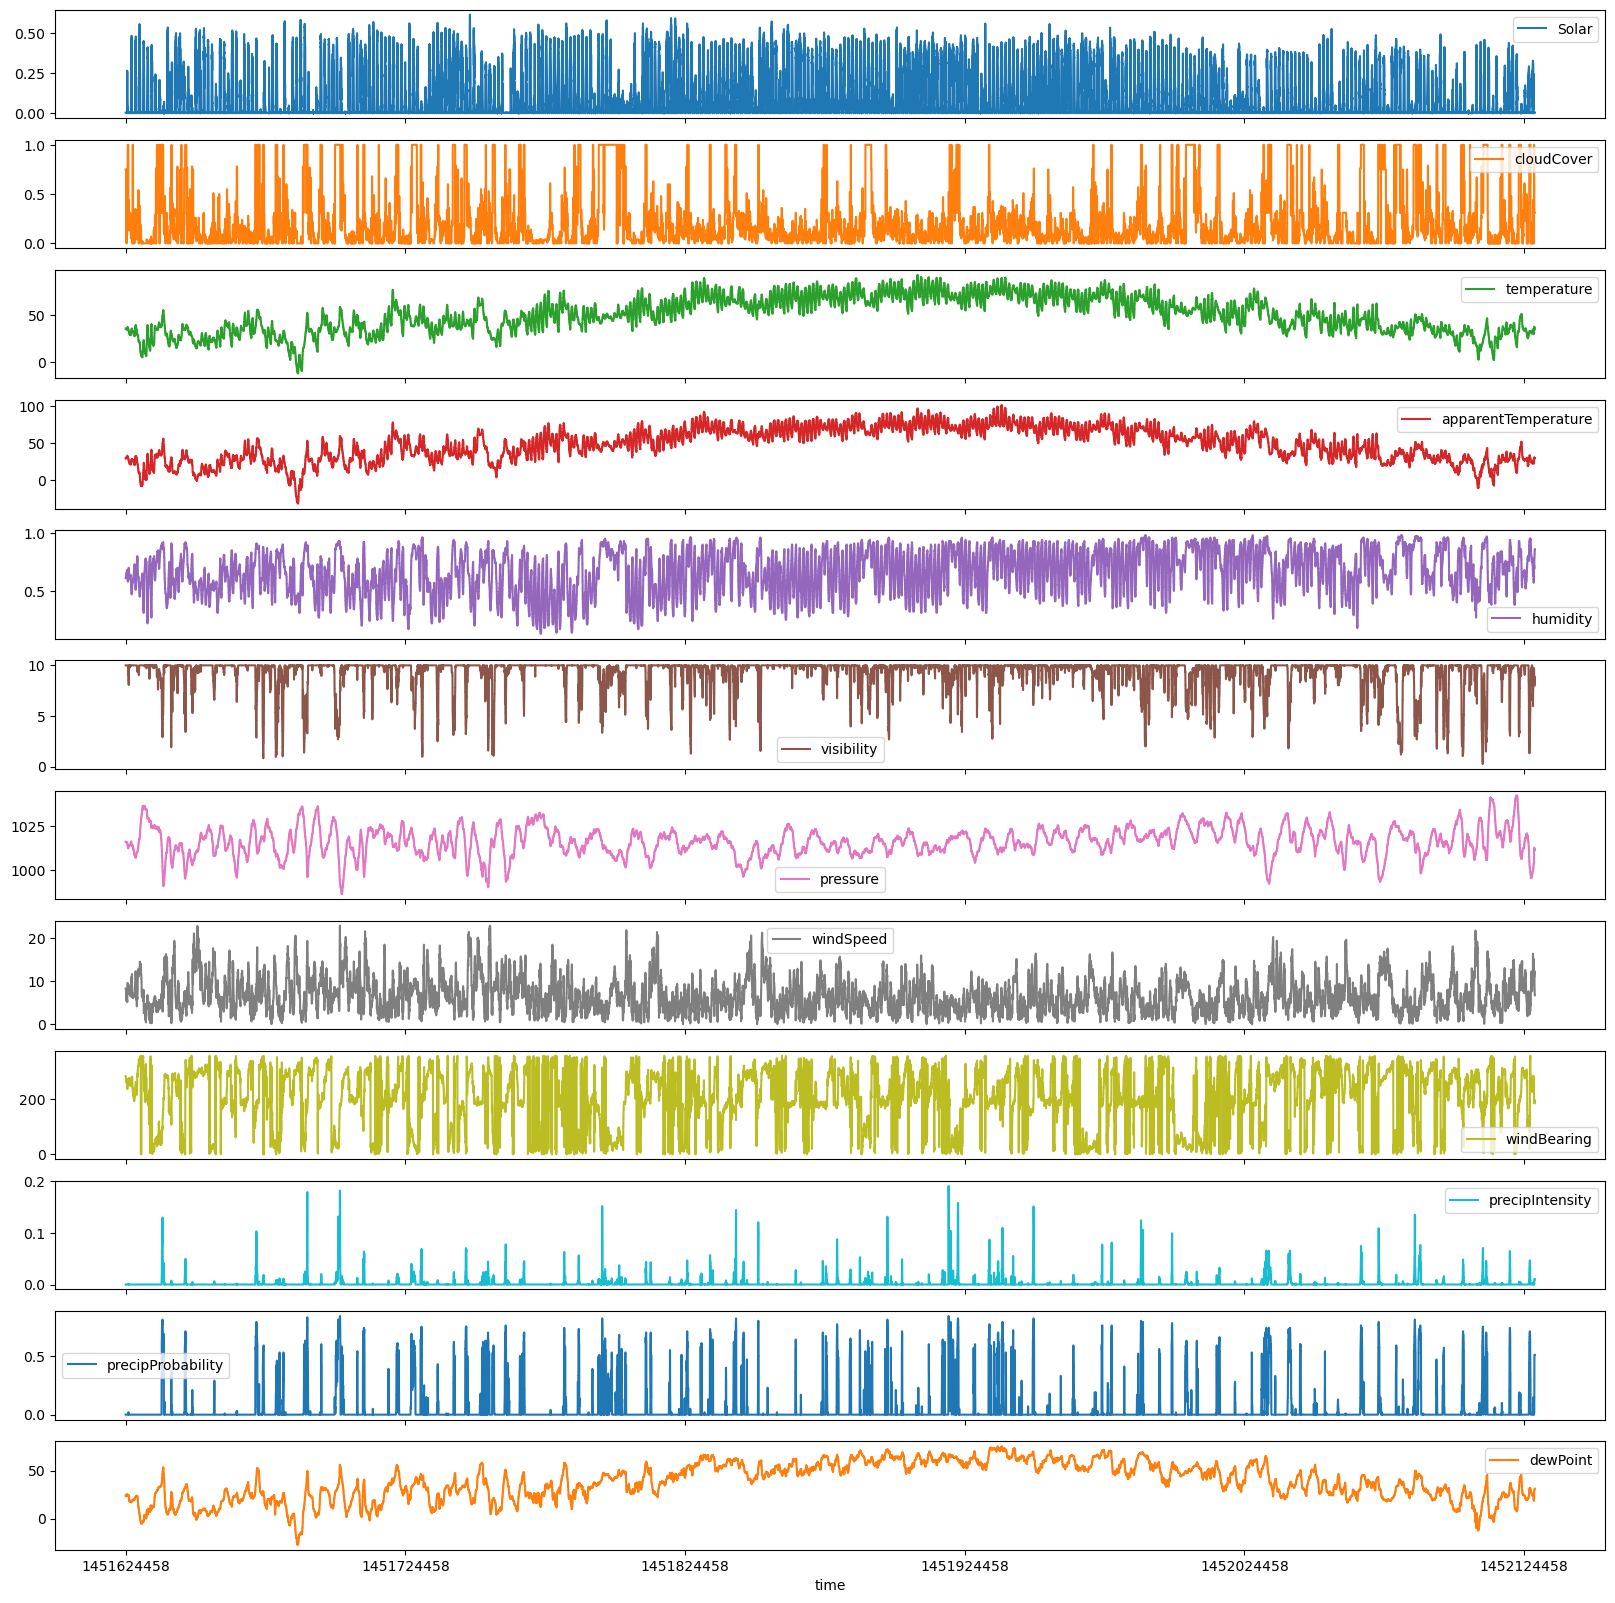

In [27]:
solar_df.plot('time', ['Solar', 'cloudCover', 'temperature', 'apparentTemperature', 'humidity', 'visibility', 'pressure', 'windSpeed', 'windBearing', 'precipIntensity', 'precipProbability', 'dewPoint'], subplots = True, figsize = (20,20))

Even though the graphs are tiny, there are a few patterns that can be picked up on.
- Solar may be inversely related to Cloud Cover and Visibility
- Temp and Apparent Temp don't seem to differ much.  I will pick Temp for initial analysis.
- Dewpoint also doesn't seem to differe much from temperature.  This likely won't be useful for modeling (dependent variable on temperature)
- Precipitation Intensity has a correlation with precipitation Probability.  For now I will pick precipIntensity as probability is a prediction and not an actual reading.

array([<Axes: xlabel='time'>, <Axes: xlabel='time'>,
       <Axes: xlabel='time'>, <Axes: xlabel='time'>,
       <Axes: xlabel='time'>, <Axes: xlabel='time'>,
       <Axes: xlabel='time'>, <Axes: xlabel='time'>,
       <Axes: xlabel='time'>], dtype=object)

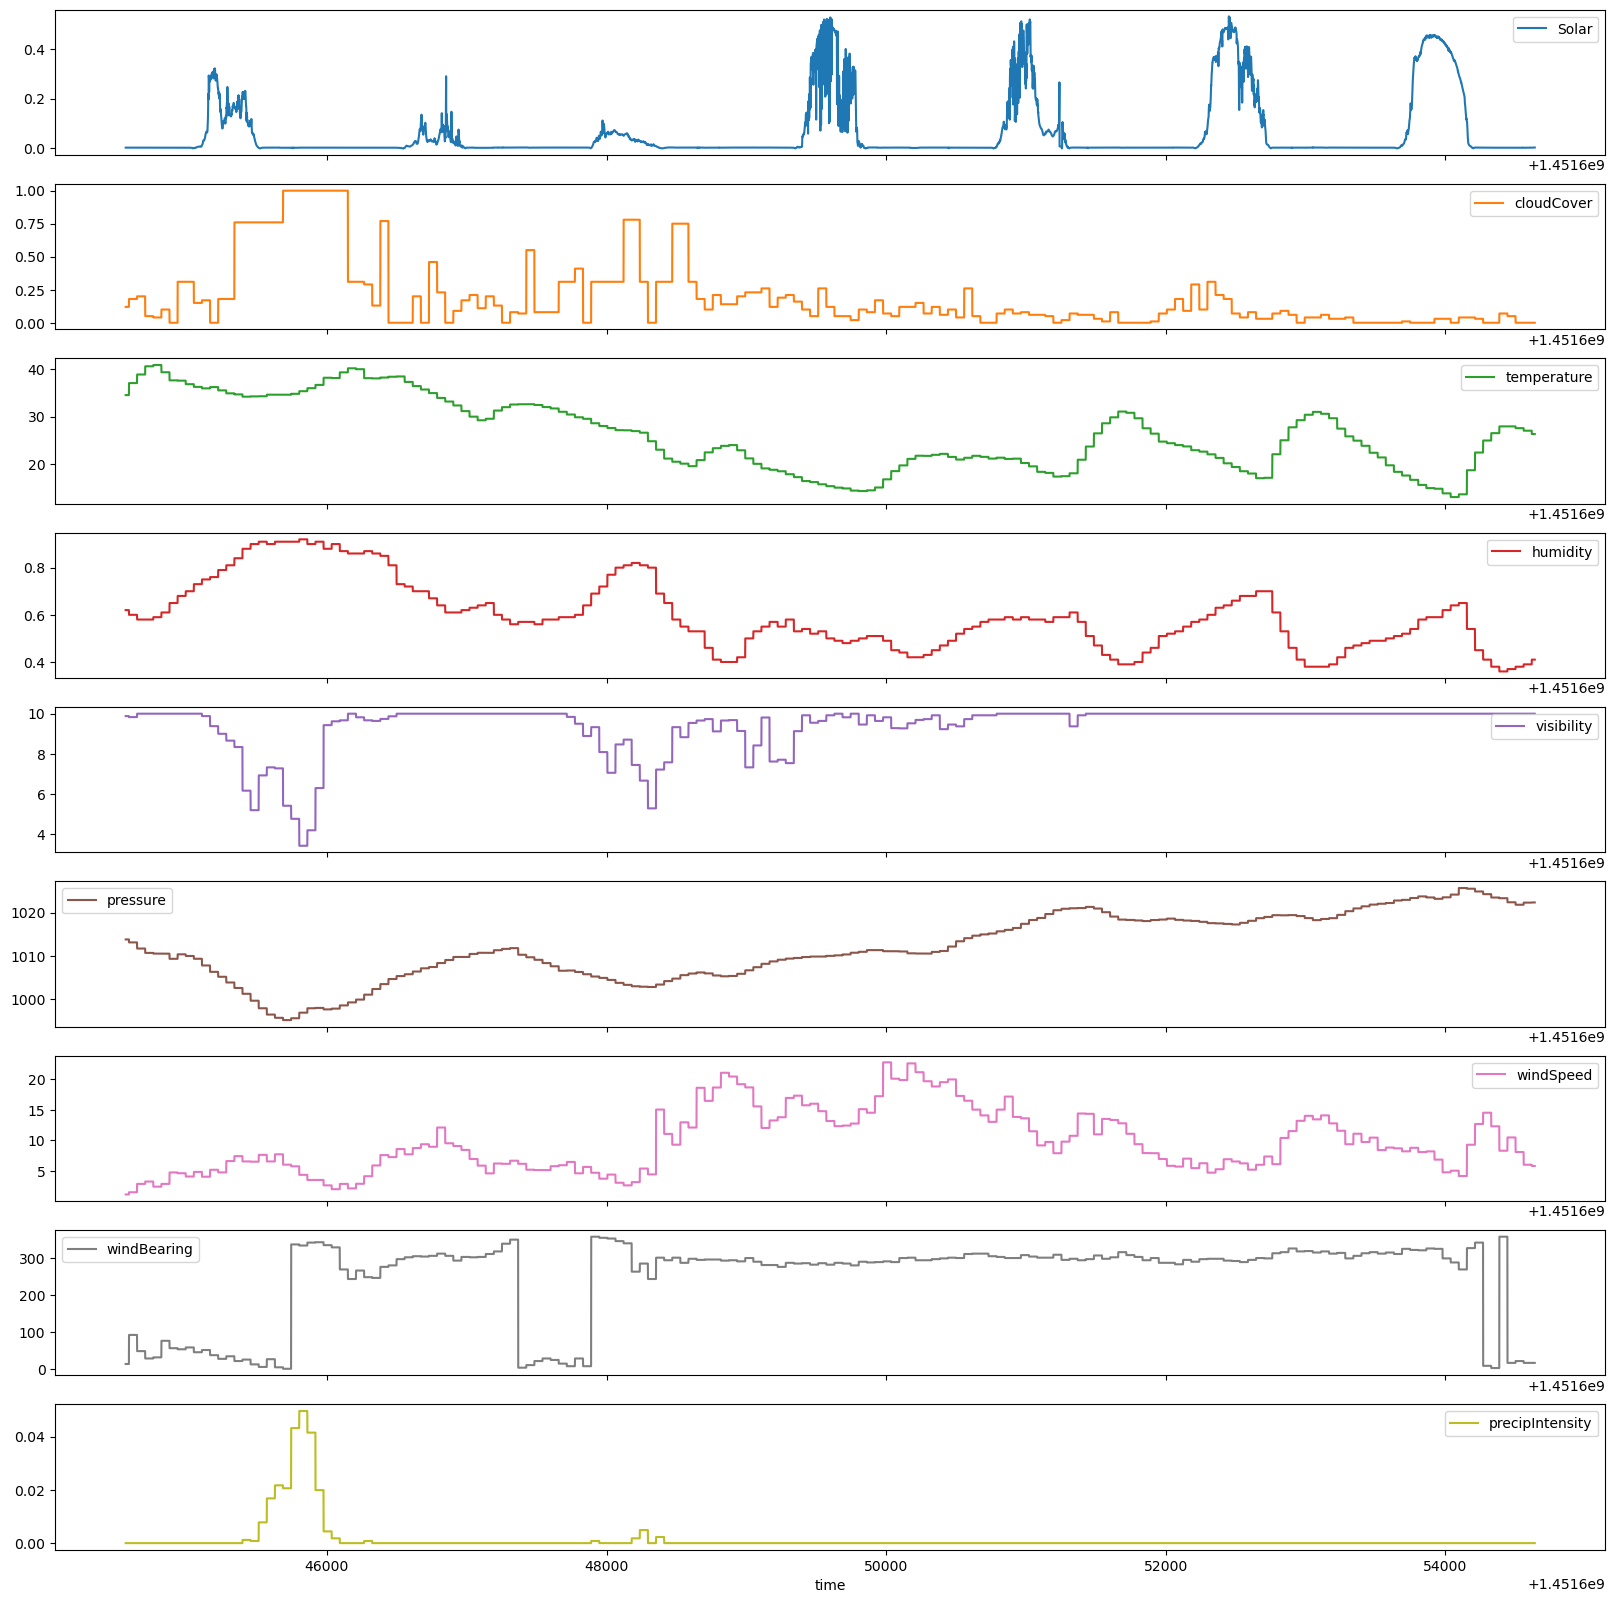

In [12]:
# Plot 7 days of dataset to see interactions with features
solar_df[20160:30240].plot('time', ['Solar', 'cloudCover', 'temperature', 'humidity', 'visibility', 'pressure', 'windSpeed', 'windBearing', 'precipIntensity'], subplots = True, figsize = (20,20))


A few more trends can be seen from this small snippet of a week:
- Temperature helps identify day/night cycles, so there is definitely a relationship there.
- Both Cloud cover and Visibilty look to be correlated to Solar generation.  Cloud cover seems slightly better of an indicator than Visibilty.
- Pressure, Humidity, Windspeed, and Windbearing don't seem to matter much.

In [7]:
#Create a Weekly rolling Average since the data is hard to read in current form
features = ['Solar', 'cloudCover', 'temperature', 'visibility', 'humidity', 'pressure', 
            'windSpeed', 'windBearing', 'precipIntensity']

solar_df[['Solar_weekly_avg', 'cloudCover_weekly_avg', 'temperature_weekly_avg', 'visibility_weekly_avg', 'humidity_weekly_avg', 'pressure_weekly_avg', 
          'windSpeed_weekly_avg', 'windBearing_weekly_avg', 'precipIntensity_weekly_avg']] = solar_df[features].rolling(10080).mean()


solar_df.tail()

,time,Solar,temperature,icon,humidity,visibility,summary,apparentTemperature,pressure,windSpeed,...,precipProbability,Solar_weekly_avg,cloudCover_weekly_avg,temperature_weekly_avg,visibility_weekly_avg,humidity_weekly_avg,pressure_weekly_avg,windSpeed_weekly_avg,windBearing_weekly_avg,precipIntensity_weekly_avg
503905,1452128305,0.003183,35.12,rain,0.86,8.74,Light Rain,29.45,1011.49,6.72,...,0.51,0.044390,0.288830,34.421676,8.912887,0.710440,1018.442798,8.036122,213.241369,0.002997
503906,1452128306,0.003233,35.12,rain,0.86,8.74,Light Rain,29.45,1011.49,6.72,...,0.51,0.044390,0.288861,34.420953,8.912762,0.710481,1018.441228,8.036152,213.234623,0.002998
503907,1452128307,0.003217,35.12,rain,0.86,8.74,Light Rain,29.45,1011.49,6.72,...,0.51,0.044390,0.288892,34.420231,8.912637,0.710522,1018.439659,8.036182,213.227877,0.002999
503908,1452128308,0.003217,35.12,rain,0.86,8.74,Light Rain,29.45,1011.49,6.72,...,0.51,0.044390,0.288923,34.419509,8.912512,0.710562,1018.438089,8.036211,213.221131,0.003000
503909,1452128309,0.003233,35.12,rain,0.86,8.74,Light Rain,29.45,1011.49,6.72,...,0.51,0.044389,0.288953,34.418787,8.912387,0.710603,1018.436520,8.036241,213.214385,0.003001


array([<Axes: xlabel='time'>, <Axes: xlabel='time'>,
       <Axes: xlabel='time'>, <Axes: xlabel='time'>,
       <Axes: xlabel='time'>, <Axes: xlabel='time'>,
       <Axes: xlabel='time'>, <Axes: xlabel='time'>,
       <Axes: xlabel='time'>], dtype=object)

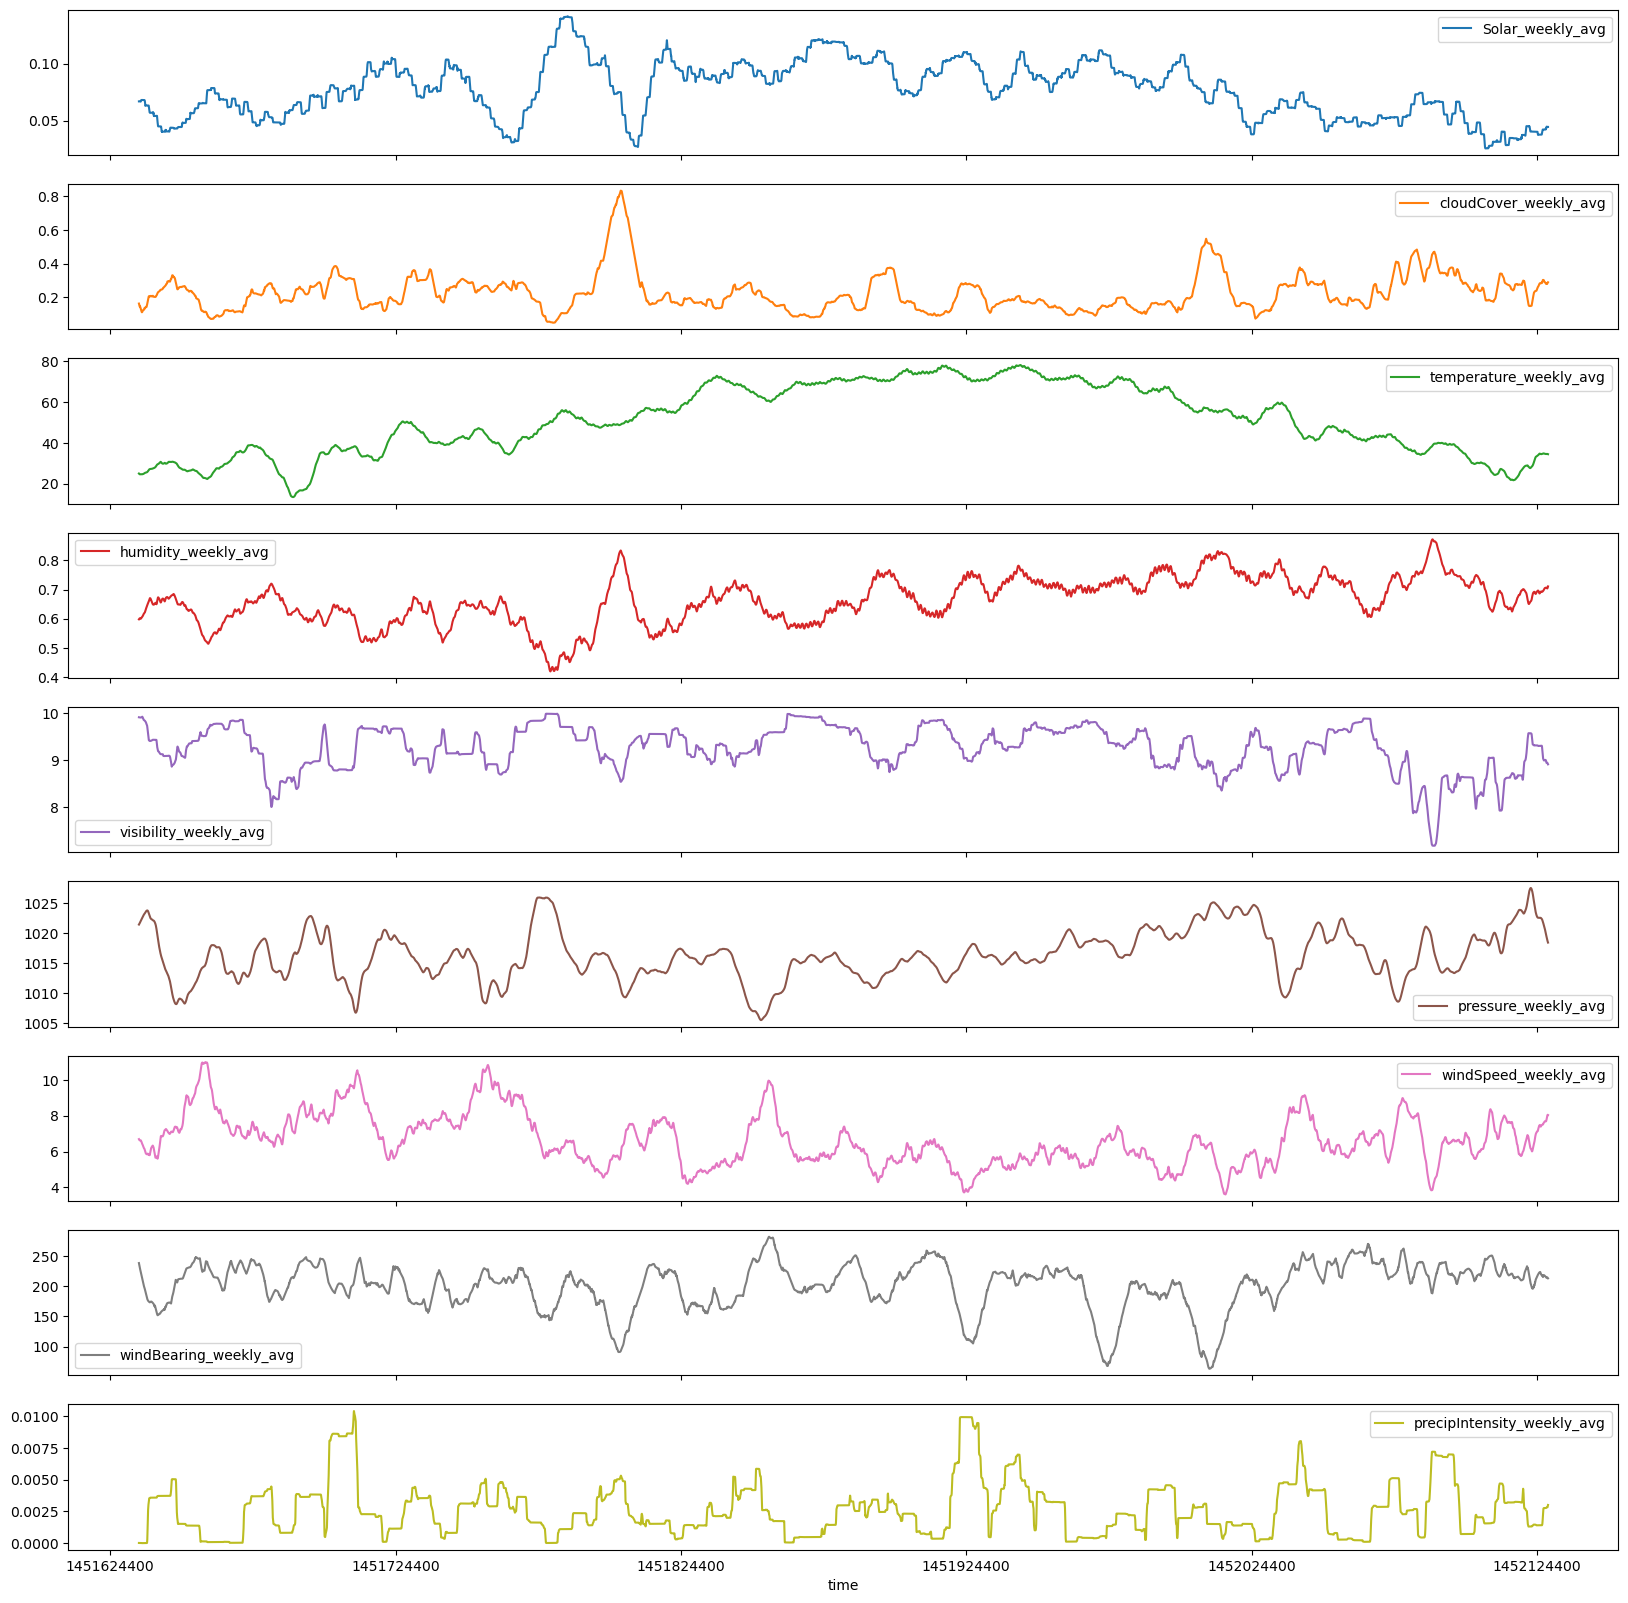

In [8]:
# Plot the weekly rolling average
solar_df.plot('time', ['Solar_weekly_avg', 'cloudCover_weekly_avg', 'temperature_weekly_avg', 'humidity_weekly_avg', 'visibility_weekly_avg', 'pressure_weekly_avg', 
                       'windSpeed_weekly_avg', 'windBearing_weekly_avg', 'precipIntensity_weekly_avg'], subplots = True, figsize = (20,20))

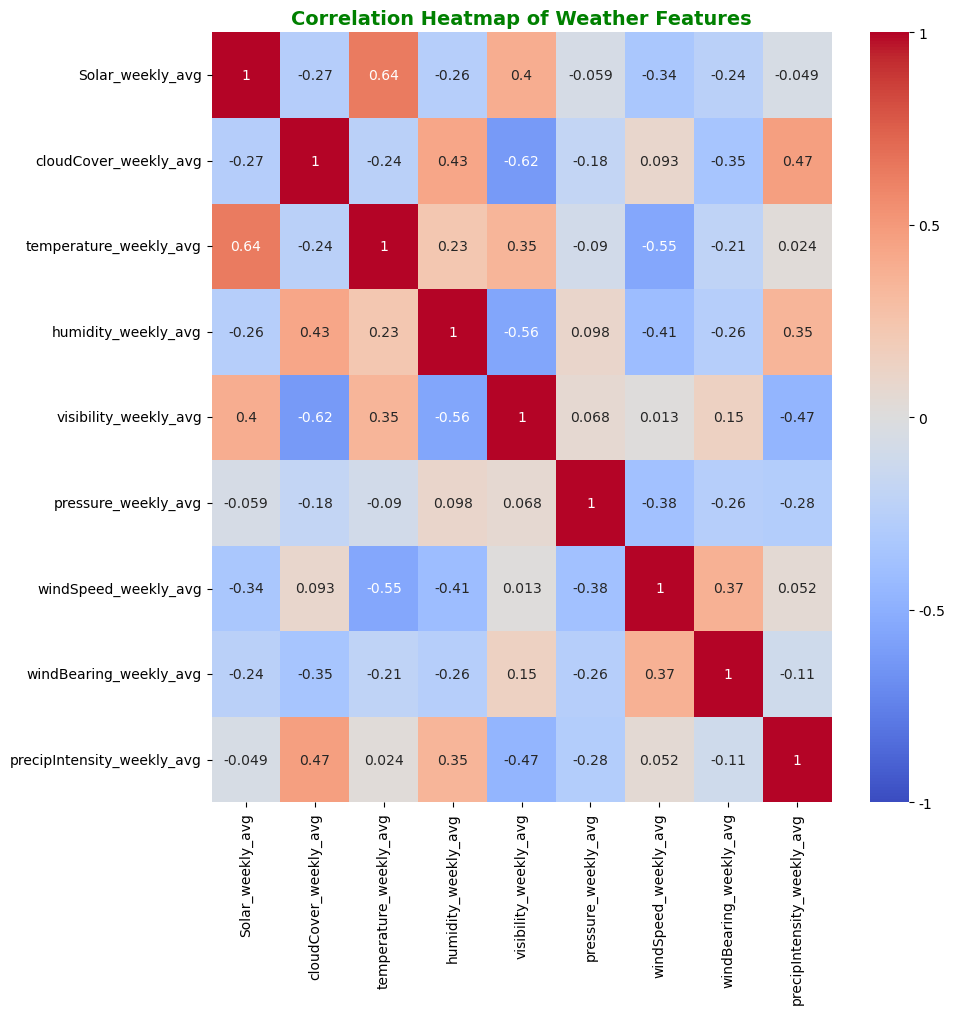

In [14]:
# Checking Correlations among features
fig, ax = plt.subplots(figsize=(10, 10)) 

# Generate a heatmap for the correlation matrix of the weather-related columns in the DataFrame 
sns.heatmap(solar_df[weekly_avg_features].corr(), annot=True, cmap='coolwarm', vmin=-1.0, vmax=1.0, center=0, ax=ax)

# Adding a title with a specified font size 
plt.title('Correlation Heatmap of Weather Features', fontsize=14, weight='bold', color='green') 

# add a color bar 
cbar = ax.collections[0].colorbar 
cbar.set_ticks([-1, -0.5, 0, 0.5, 1]) 
cbar.set_ticklabels(['-1', '-0.5', '0', '0.5', '1']) 
plt.show()

Looking at the heatmap for weekly averages shows a little more detail on how the features interact with each other and with Solar.
- There is a correlation between Solar and Temperature, as we saw in the graph.
- There is a negative correlation between Cloud Cover and Visibility, so we should only choose one of these.
- Visibility seems to have a slightly higher correlation with Solar, so we will experiment with that one.
- The rest of the featuers don't have much impact on solar, except for a possible weak negative correlation between Solar and Wind speed.